**Updates Nov 10th, 2018**
* OpenSlide can now be installed in Colab.
* A folder containing example slides and tumor masks is linked below. These should be sufficient for your project. The goal is to build a working end-to-end prototype, not to match the accuracy from the papers (or to train on a giant amount of data).


---


Below is an example program that shows how to read slides and tumor masks from the [CAMELYON16](https://camelyon17.grand-challenge.org/Data/) dataset. 

* To run this code, first you will need to install [OpenSlide](https://openslide.org/), the only non-Python dependency. 

* You can find a folder of slides and tumor masks [here](https://drive.google.com/drive/folders/1rwWL8zU9v0M27BtQKI52bF6bVLW82RL5?usp=sharing). There are 22 slides and tissue masks. The tissue masks were produced using [ASAP](https://github.com/computationalpathologygroup/ASAP) and the instructions on the competition website. I did this in advance for you, so you wouldn't have to spend energy installing ASAP (it has a variety of dependencies, depending on your OS). This way, you'll only need to install OpenSlide.

* This amount of data should be more than sufficient for our project. (If you'd like to work with more, you will need to produce tissue masks yourself using ASAP). 


* OpenSlide also includes a [DeepZoom viewer](https://github.com/openslide/openslide-python/tree/master/examples/deepzoom) you can use to view the tissue images (after installing open slide, clone that repo, `cd` into the examples, and run `python deepzoom_server.py`. You will need install open slide on your computer, and run this notebook locally for that to work.







In [217]:
# Install the OpenSlide C library and Python bindings
!apt-get install openslide-tools
!pip install openslide-python

Reading package lists... Done
Building dependency tree       
Reading state information... Done
openslide-tools is already the newest version (3.4.1+dfsg-2).
0 upgraded, 0 newly installed, 0 to remove and 8 not upgraded.


In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from openslide import open_slide, __library_version__ as openslide_version
import os
from PIL import Image
from skimage.color import rgb2gray
import tensorflow as tf
import math

In [0]:
# # Download an example slide and tumor mask
# # Note: these are hosted on Google Cloud Storage.
# # The remainder are in a Google Drive folder, linked above.

# slide_path = 'tumor_091.tif'
# tumor_mask_path = 'tumor_091_mask.tif'

# slide_url = 'https://storage.googleapis.com/applied-dl/%s' % slide_path
# mask_url = 'https://storage.googleapis.com/applied-dl/%s' % tumor_mask_path

# # Download the whole slide image
# if not os.path.exists(slide_path):
#   !curl -O $slide_url

# # Download the tumor mask
# if not os.path.exists(tumor_mask_path):
#   !curl -O $mask_url

In [0]:
# slide = open_slide(slide_path)
# print ("Read WSI from %s with width: %d, height: %d" % (slide_path, 
#                                                         slide.level_dimensions[0][0], 
#                                                         slide.level_dimensions[0][1]))

# tumor_mask = open_slide(tumor_mask_path)
# print ("Read tumor mask from %s" % (tumor_mask_path))

# print("Slide includes %d levels", len(slide.level_dimensions))
# for i in range(len(slide.level_dimensions)):
#     print("Level %d, dimensions: %s downsample factor %d" % (i, 
#                                                              slide.level_dimensions[i], 
#                                                              slide.level_downsamples[i]))
#     assert tumor_mask.level_dimensions[i][0] == slide.level_dimensions[i][0]
#     assert tumor_mask.level_dimensions[i][1] == slide.level_dimensions[i][1]

# # Verify downsampling works as expected
# width, height = slide.level_dimensions[7]
# assert width * slide.level_downsamples[7] == slide.level_dimensions[0][0]
# assert height * slide.level_downsamples[7] == slide.level_dimensions[0][1]

## Downloading new images

In [0]:
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once per notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [0]:
# See https://openslide.org/api/python/#openslide.OpenSlide.read_region
# Note: x,y coords are with respect to level 0.
# There is an example below of working with coordinates
# with respect to a higher zoom level.

# Read a region from the slide
# Return a numpy RBG array
def read_slide(slide, x, y, level, width, height, as_float=False):
    im = slide.read_region((x,y), level, (width, height))
    im = im.convert('RGB') # drop the alpha channel
    if as_float:
        im = np.asarray(im, dtype=np.float32)
    else:
        im = np.asarray(im)
    assert im.shape == (height, width, 3)
    return im

In [0]:
# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Download a file based on its file ID.
#tumor_110
slide1_id = '1tCvyQIXadK0TSJlrwmkQ38caD1HsjevQ'
slideFile1 = drive.CreateFile({'id': slide1_id})
mask1_id = '1jZKrrj-mat0J_ur0CNhkeoYD1Fu-DtJu'
maskFile1 = drive.CreateFile({'id': mask1_id})

#tumor_101
slide2_id = '1vhm5D7106bsCRcf2aTp8r3Y1GLjAsRt_'
slideFile2 = drive.CreateFile({'id': slide2_id})
mask2_id = '1zx_wc1SHnlz_umsqLB0xV13KcVvnbRD3'
maskFile2 = drive.CreateFile({'id': mask2_id})

#094
slide3_id = '1n2pIh-2-wTO0Er5YKye-84YEFsbpq2UH'
slideFile3 = drive.CreateFile({'id': slide3_id})
mask3_id = '1ngSHKv9aM8irpP69lziNVYaEo5hxkDnP'
maskFile3 = drive.CreateFile({'id': mask3_id})

#091
slide4_id = '11RzjCE_ySgk10IPAJEwv4bfgmaBT2dJP'
slideFile4 = drive.CreateFile({'id': slide4_id})
mask4_id = '1hopHZjnPwR7IHMozgJDBre5rdvR_zx0Y'
maskFile4 = drive.CreateFile({'id': mask4_id})

#084
slide5_id = '1fnNUMAhZV5zkFP8joNZ3WexaWSywdtgI'
slideFile5 = drive.CreateFile({'id': slide5_id})
mask5_id = '1OWJQkLp2aMOtAqNQVXWacNN-S3P00bA3'
maskFile5 = drive.CreateFile({'id': mask5_id})


In [0]:
# print('Created file %s with mimeType %s' % (slideFile['title'], slideFile['mimeType']))
# print('Created file %s with mimeType %s' % (maskFile['title'], maskFile['mimeType']))

In [0]:
slideFile1.GetContentFile("tumor_110.tif")
maskFile1.GetContentFile("tumor_110_mask.tif")

slideFile2.GetContentFile("tumor_101.tif")
maskFile2.GetContentFile("tumor_101_mask.tif")

slideFile3.GetContentFile("tumor_094.tif")
maskFile3.GetContentFile("tumor_094_mask.tif")

slideFile4.GetContentFile("tumor_091.tif")
maskFile4.GetContentFile("tumor_091_mask.tif")

slideFile5.GetContentFile("tumor_084.tif")
maskFile5.GetContentFile("tumor_084_mask.tif")

In [0]:
slide1 = open_slide("tumor_110.tif")
tumor_mask1 = open_slide("tumor_110_mask.tif")

slide2 = open_slide("tumor_101.tif")
tumor_mask2 = open_slide("tumor_101_mask.tif")

slide3 = open_slide("tumor_094.tif")
tumor_mask3 = open_slide("tumor_094_mask.tif")

slide4 = open_slide("tumor_091.tif")
tumor_mask4 = open_slide("tumor_091_mask.tif")

slide5 = open_slide("tumor_084.tif")
tumor_mask5 = open_slide("tumor_084_mask.tif")

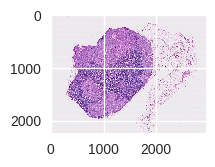

In [11]:
slide_image1 = read_slide(slide1, x=0, y=0, level=5, 
                          width=slide1.level_dimensions[5][0], height=slide1.level_dimensions[5][1])

plt.figure(figsize=(2,2), dpi=100)
plt.imshow(slide_image1)

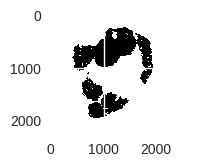

In [12]:
mask_image1 = read_slide(tumor_mask1, x=0, y=0, level=5, 
                        width=slide1.level_dimensions[5][0], height=slide1.level_dimensions[5][1])

# Note: the program provided by the dataset authors generates a mask with R,G,B channels.
# The mask info we need is in the first channel only.
# If you skip this step, the mask will be displayed as all black.
mask_image1 = mask_image1[:,:,0]
#print(mask_image.shape)
plt.figure(figsize=(2,2), dpi=100)
plt.imshow(mask_image1)

In [296]:
# slide_image2 = read_slide(slide2, x=0, y=0, level=5, 
#                           width=slide2.level_dimensions[5][0], height=slide2.level_dimensions[5][1])
# slide_image3 = read_slide(slide3, x=0, y=0, level=5, 
#                           width=slide3.level_dimensions[5][0], height=slide3.level_dimensions[5][1])
# slide_image4 = read_slide(slide4, x=0, y=0, level=5, 
#                           width=slide4.level_dimensions[5][0], height=slide4.level_dimensions[5][1])
# slide_image5 = read_slide(slide5, x=0, y=0, level=5, 
#                           width=slide5.level_dimensions[5][0], height=slide5.level_dimensions[5][1])

# mask_image2 = read_slide(tumor_mask2, x=0, y=0, level=5, 
#                         width=slide2.level_dimensions[5][0], height=slide2.level_dimensions[5][1])
# mask_image2 = mask_image2[:,:,0]

# mask_image3 = read_slide(tumor_mask3, x=0, y=0, level=5, 
#                         width=slide3.level_dimensions[5][0], height=slide3.level_dimensions[5][1])
# mask_image3 = mask_image3[:,:,0]

# mask_image4 = read_slide(tumor_mask4, x=0, y=0, level=5, 
#                         width=slide4.level_dimensions[5][0], height=slide4.level_dimensions[5][1])
# mask_image4 = mask_image4[:,:,0]

# mask_image5 = read_slide(tumor_mask5, x=0, y=0, level=5, 
#                         width=slide5.level_dimensions[5][0], height=slide5.level_dimensions[5][1])
# mask_image5 = mask_image5[:,:,0]


#slide_list = [slide_image1, slide_image2, slide_image3, slide_image4, slide_image5]
#mask_list = [mask_image1, mask_image2, mask_image3, mask_image4, mask_image5]

slide_list = [slide_image1, slide_image2, slide_image4]
mask_list = [mask_image1, mask_image2, mask_image4]
print(len(slide_list), len(mask_list))

3 3


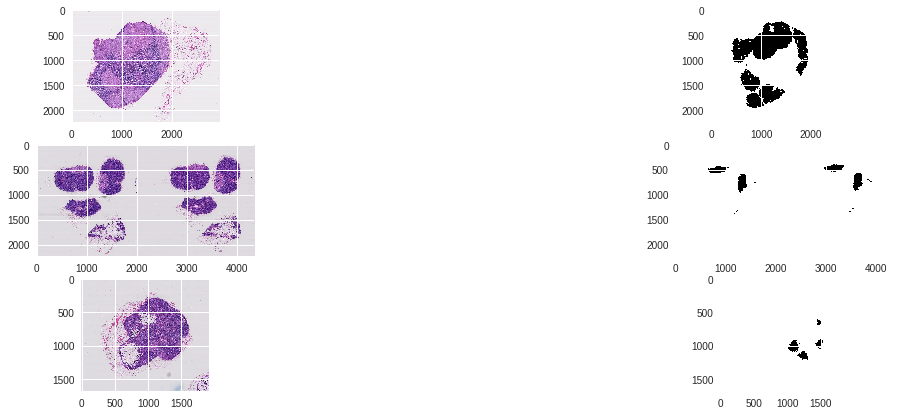

In [297]:
fig,ax=plt.subplots(3,2,figsize=(21,7))

for i in range(len(slide_list)):
    ax[i][0].imshow(slide_list[i])
    ax[i][1].imshow(mask_list[i])

#ax[0].imshow(slide_image1)
# colors = {}
# colors[0]='purple'
# colors[1]='teal'
# colors[2]='gold'
# for name, points in groups:
#     ax[0].scatter(points.x, points.y,c=colors[name],label=label_names[name], alpha = 0.1)
#     ax[1].scatter(points.x, points.z,c=colors[name],label=label_names[name], alpha = 0.1)
#     ax[2].scatter(points.y, points.z,c=colors[name],label=label_names[name], alpha = 0.1)
#     #ax[0].legend([h],'hi')

# ax[2].legend(loc='center left', bbox_to_anchor=(1, 0.5))

## Overlay images

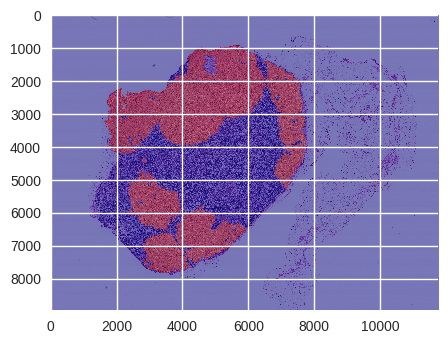

In [14]:
# Overlay them. The idea is that the mask shows the region of the slide that
# contain cancerous cells.

plt.figure(figsize=(5,5), dpi=100)
plt.imshow(slide_image1)
plt.imshow(mask_image1, cmap='jet', alpha=0.5) # Red regions contains cancer.

In [0]:
# # Example: extract a region from the L7 downsampled image
# # Notice we're multiplying the x,y coordinates by the downsample factor.
# # This math can be tricky to get right, debug carefully.
# # Here, we're "aiming" for the top right blob in the image above.
# region = read_slide(tumor_mask, x=350 * 128, y=120 * 128, level=7, width=50, height=50)[:,:,0]
# #region = read_slide(tumor_mask, x=400 * 128, y=450 * 128, level=7, width=50, height=50)[:,:,0]
# plt.imshow(region)

## Heatmap Function

In [0]:
def gen_heatmap(slide_image, x_test, model, thres=0.9):
  import math
  width_lim = math.ceil(slide_image.shape[0]/40)
  height_lim = math.ceil(slide_image.shape[1]/40)

  print(width_lim, height_lim)

  base = np.zeros((width_lim, height_lim))
  pred = model.predict(x_test)[:,1]
  pred_thres = pred.copy()
  np.place(pred_thres, pred_thres<thres, 0)
  pred_1 = pred.reshape((int(slide_image.shape[0]/40), math.ceil(slide_image.shape[1]/40)))
  pred_2 = pred_thres.reshape((int(slide_image.shape[0]/40), math.ceil(slide_image.shape[1]/40)))
  print(pred_1.shape)
  print(pred_2.shape)
  
  #xticks = [0, 500, 1000, 1500, 2000, 2500]
  #yticks = [0, 250, 500, 750, 1000, 1250, 1500, 1750]
  #yticks = list(reversed(yticks))
  
  #plt.figure(figsize=(height_lim/10, width_lim/10), dpi=100)

  import seaborn
  fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5))

  seaborn.heatmap(pred_1, cmap='YlGnBu',yticklabels=7, xticklabels=13,linewidths=0.005, ax=ax1)
  seaborn.heatmap(pred_2, cmap='YlGnBu',yticklabels=7, xticklabels=13,linewidths=0.005, ax=ax2)
  ax1.set_title('No Threshold')
  ax2.set_title('Threshold at '+ str(thres))
  plt.show()

## Generating Training set (discarding non-tissue regions)

In [0]:
# As mentioned in class, we can improve efficiency by ignoring non-tissue areas 
# of the slide. We'll find these by looking for all gray regions.
def find_tissue_pixels(image, intensity=0.8):
    im_gray = rgb2gray(image)
    assert im_gray.shape == (image.shape[0], image.shape[1])
    indices = np.where(im_gray <= intensity)
    return list(zip(indices[0], indices[1]))

#tissue_pixels = find_tissue_pixels(slide_image)
#percent_tissue = len(tissue_pixels) / float(slide_image.shape[0] * slide_image.shape[0]) * 100
#print ("%d tissue_pixels pixels (%.1f percent of the image)" % (len(tissue_pixels), percent_tissue)) 

def apply_mask(im, mask, color=(255,0,0)):
    masked = np.copy(im)
    for x,y in mask: masked[x][y] = color
    return masked

#tissue_regions = apply_mask(slide_image, tissue_pixels)
#plt.imshow(tissue_regions)

In [250]:
# (w_width, w_height) = (40, 40)

# print(slide_image3.shape[0]/w_width)
# print(slide_image3.shape[1]/w_height)
# slide_image3.shape

78.4
92.8


(3136, 3712, 3)

In [0]:
def sliding_window(image, tumor_image, tissueregion, stepSize=40, w_width=40, w_height=40, training = True):
	# slide a window across the image
  if training:
    for x in range(0, image.shape[0], stepSize):
      for y in range(0, image.shape[1], stepSize):
        image_ = image[x:x+w_width, y:y+w_height]
        tissue_ = tissueregion[x:x+w_width, y:y+w_height]
        if image_.shape[0]*image_.shape[1] < w_width*w_height:
          image_ = np.pad(image_, 
                             ((0, w_width - image_.shape[0]), (0, w_height - image_.shape[1]),
                             (0,0)), 'constant', constant_values = (0))
        tissue_ = tissue_.reshape(tissue_.shape[0]*tissue_.shape[1], 3)
        if np.all(tissue_ == np.array([255, 0, 0]), axis = 1).any():
          yield image_, math.ceil(np.mean(tumor_image[x:x+w_width, y:y+w_height]))
  else:
    for x in range(0, image.shape[0], stepSize):
      for y in range(0, image.shape[1], stepSize):
        image_ = image[x:x+w_width, y:y+w_height]
        if image_.shape[0]*image_.shape[1] < w_width*w_height:
          image_ = np.pad(image_, 
                             ((0, w_width - image_.shape[0]), (0, w_height - image_.shape[1]),
                             (0,0)), 'constant', constant_values = (0))
        
        yield image_, math.ceil(np.mean(tumor_image[x:x+w_width, y:y+w_height]))


In [252]:
slide_image3.shape[0]/40 , math.ceil(slide_image3.shape[1]/40)

(78.4, 93)

In [0]:
def image_to_array(slide, mask, train=True):
  tissue_pixels = find_tissue_pixels(slide)
  tissue_regions = apply_mask(slide, tissue_pixels)
  x_patches, y_patches = zip(*sliding_window(slide, mask, tissue_regions, training=train))

  x_patches = np.array([patch for patch in x_patches])
  y_patches = np.array([patch for patch in y_patches])
  #assert X_patches.shape[0] == len(X_indices)
  #print(X_patches1.shape, y_patches1.shape)
  return x_patches, y_patches
  

In [301]:
k = len(slide_list)-1

x_train = []
y_train = []

for i in range(k):
  slide = slide_list[i]
  mask = mask_list[i]
  
  x, y = image_to_array(slide,mask)
  
  print(x.shape, y.shape)
  
  x_train += [x]
  y_train += [y]


x_train = np.vstack(x_train)
y_train = np.hstack(y_train)
  
x_test, y_test = image_to_array(slide_list[k], mask_list[k],train=False)

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(2262, 40, 40, 3) (2262,)
(2893, 40, 40, 3) (2893,)
(5155, 40, 40, 3)
(5155,)
(2016, 40, 40, 3)
(2016,)


In [302]:
from collections import Counter
print('Training Class')
print(Counter(y_train))

print('Testing Class')
print(Counter(y_test))

Training Class
Counter({0: 4122, 1: 1033})
Testing Class
Counter({0: 1946, 1: 70})


In [0]:
def undersampling(X, y):
  majority_index = np.where(y == 0)[0]
  m = (y == 1).sum()
  
  sample_index = np.random.choice(majority_index, size = m, replace = False)
  
  X_sample = np.concatenate((X[sample_index], X[np.where(y == 1)]))
  y_sample = np.concatenate((y[sample_index], y[np.where(y == 1)]))
  
  shuffle_index = np.arange(X_sample.shape[0])
  np.random.shuffle(shuffle_index)
  
  X_sample = X_sample[shuffle_index]
  y_sample = y_sample[shuffle_index]
  
  return X_sample, y_sample

In [0]:
def oversampling(x,y):
  minority_index = np.where(y == 1)[0]
  m = np.sum(y == 0)
  sample_index = np.random.choice(minority_index, m, replace = True)
  x_new = np.concatenate((x[sample_index], x[np.where(y ==0)]))
  y_new = np.concatenate((y[sample_index], y[np.where(y ==0)]))
  
  shuffle_index = np.arange(x_new.shape[0])
  np.random.shuffle(shuffle_index)

  x_new = x_new[shuffle_index]
  y_new = y_new[shuffle_index]
  
  return x_new, y_new

In [0]:
X_sample, y_sample = oversampling(x_train, y_train)

In [306]:
print('0 class: ', (y_sample==0).sum())
print('1 class: ', (y_sample == 1).sum())

0 class:  4122
1 class:  4122


Data Augmentation

In [0]:
#train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
#            rotation_range = 40,
#            width_shift_range = 0.2,
#            height_shift_range = 0.2, 
#            horizontal_flip = True,
#            vertical_flip = True,
#            fill_mode = 'nearest')

In [0]:
#test_datagen = tf.keras.preprocessing.image.ImageDataGenerator()

In [0]:
# i = 0
# for batch in train_datagen.flow(X_sample, batch_size = 5):
#   plt.figure(i)
#   imgplot = plt.imshow(tf.keras.preprocessing.image.array_to_img(batch[0].reshape(40,40,3)))
#   i += 1
#   if i %10 == 0:
#     break

# plt.show()

In [0]:
# X_sample2, X_val, y_sample2, y_val = train_test_split(X_sample, y_sample, test_size = 0.1)

In [0]:
# train_datagen.fit(X_sample2)

## Baseline Model

In [0]:
import tensorflow as tf
vgg16 = tf.keras.applications.VGG16(weights = 'imagenet',input_shape=(40, 40, 3), include_top=False)
vgg16.trainable=False

In [312]:
model_baseline = tf.keras.Sequential([
  vgg16,
  #xception,
  tf.keras.layers.GlobalAveragePooling2D(),
  #tf.keras.layers.Flatten(), 
  #tf.keras.layers.Dense(256, activation='relu'),
  #tf.keras.layers.Dropout(0.3), # Add dropout to reduce overfitting
  tf.keras.layers.Dense(128, activation = 'relu'),
  #tf.keras.layers.Dropout(0.3),
  tf.keras.layers.Dense(2, activation = 'softmax')])

model_baseline.compile(optimizer=tf.keras.optimizers.SGD(lr=0.0001, momentum = 0.9), 
            loss=tf.keras.losses.sparse_categorical_crossentropy,
            metrics=['accuracy'])

model_baseline.summary()

#optimizer=tf.train.AdamOptimizer()
#optimizer=tf.keras.optimizers.SGD(lr=0.0001, momentum = 0.9)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 1, 1, 512)         14714688  
_________________________________________________________________
global_average_pooling2d_3 ( (None, 512)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               65664     
_________________________________________________________________
dense_7 (Dense)              (None, 2)                 258       
Total params: 14,780,610
Trainable params: 65,922
Non-trainable params: 14,714,688
_________________________________________________________________


Pre-trained model

In [313]:
model_baseline.fit(X_sample, y_sample, batch_size = 64, epochs = 20, validation_split = 0.1)

Train on 7419 samples, validate on 825 samples
Epoch 1/20
7419/7419 [==============================] - 5s 733us/step - loss: 2.8854 - acc: 0.7102 - val_loss: 0.8808 - val_acc: 0.8242
Epoch 2/20
7419/7419 [==============================] - 5s 670us/step - loss: 0.7021 - acc: 0.8225 - val_loss: 0.5173 - val_acc: 0.8327
Epoch 3/20
7419/7419 [==============================] - 5s 669us/step - loss: 0.4763 - acc: 0.8585 - val_loss: 0.3862 - val_acc: 0.8642
Epoch 4/20
7419/7419 [==============================] - 5s 667us/step - loss: 0.3858 - acc: 0.8730 - val_loss: 0.3481 - val_acc: 0.8788
Epoch 5/20
7419/7419 [==============================] - 5s 670us/step - loss: 0.3461 - acc: 0.8834 - val_loss: 0.3421 - val_acc: 0.8788
Epoch 6/20
7419/7419 [==============================] - 5s 671us/step - loss: 0.3070 - acc: 0.8911 - val_loss: 0.3749 - val_acc: 0.8679
Epoch 7/20
7419/7419 [==============================] - 5s 668us/step - loss: 0.2846 - acc: 0.8973 - val_loss: 0.2907 - val_acc: 0.8933
E

In [319]:
from sklearn.metrics import roc_curve,  precision_score, recall_score, f1_score, average_precision_score, auc

y_predict_label = model_baseline.predict(X_sample).argmax(axis = 1)

print('Train Evaluation\n')

print('Recall: ', recall_score(y_sample, y_predict_label))
print('F1: ', f1_score(y_sample, y_predict_label))
print('Precision: ', precision_score(y_sample, y_predict_label))
print('Average Precision: ', average_precision_score(y_sample, y_predict_label))

Train Evaluation

Recall:  0.9582726831635129
F1:  0.9402523208759819
Precision:  0.9228971962616822
Average Precision:  0.9052508309640089


In [315]:
print('Test 0 class: ', (y_test==0).sum())
print('Test 1 class: ', (y_test == 1).sum())

Test 0 class:  1946
Test 1 class:  70


In [325]:
y_pred = model_baseline.predict(x_test).argmax(axis =1)
y_pred.mean()

0.08928571428571429

In [326]:
from sklearn.metrics import roc_curve,  precision_score, recall_score, f1_score
print('Test Set Evaluation\n')

evaluation = model_baseline.evaluate(x_test, y_test)

print('Loss: ', evaluation[0])
print('Accuracy: ', evaluation[1])

print('Recall: ', recall_score(y_test, y_pred))
print('F1: ', f1_score(y_test, y_pred))
print('Precision: ', precision_score(y_test, y_pred))
print('Average Precision: ', average_precision_score(y_test, y_pred))

Test Set Evaluation

2016/2016 [==============================] - 1s 723us/step
Loss:  0.22771167134245238
Accuracy:  0.9216269841269841
Recall:  0.6571428571428571
F1:  0.36799999999999994
Precision:  0.25555555555555554
Average Precision:  0.17984126984126983


42 48
(42, 48)
(42, 48)


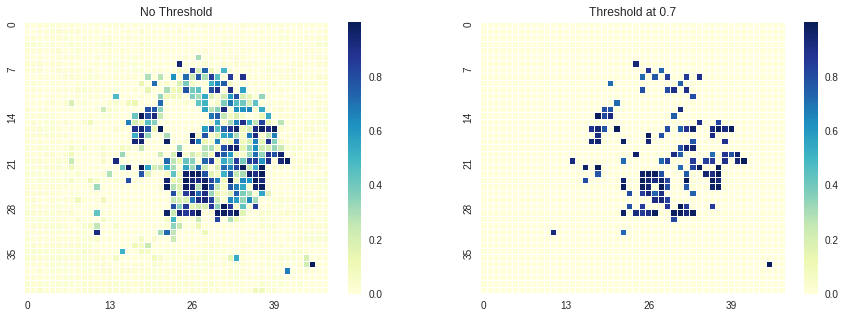

In [329]:
print('Baseline Model')
gen_heatmap(slide_image4, x_test, model_baseline, thres=0.7)

## Fine-tuning

In [0]:
vgg16_1 = tf.keras.applications.VGG16(weights = 'imagenet',input_shape=(40, 40, 3), include_top=False)
vgg16_1.trainable=False

In [322]:
model_ft = tf.keras.Sequential([
  vgg16_1,
  #xception,
  tf.keras.layers.GlobalAveragePooling2D(),
  #tf.keras.layers.Flatten(), 
  #tf.keras.layers.Dense(256, activation='relu'),
  #tf.keras.layers.Dropout(0.3), # Add dropout to reduce overfitting
  tf.keras.layers.Dense(128, activation = 'relu'),
  #tf.keras.layers.Dropout(0.3),
  tf.keras.layers.Dense(2, activation = 'softmax')])

model_ft.compile(optimizer=tf.keras.optimizers.SGD(lr=0.0001, momentum = 0.9), 
            loss=tf.keras.losses.sparse_categorical_crossentropy,
            metrics=['accuracy'])

model_ft.summary()

#optimizer=tf.train.AdamOptimizer()
#optimizer=tf.keras.optimizers.SGD(lr=0.0001, momentum = 0.9)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 1, 1, 512)         14714688  
_________________________________________________________________
global_average_pooling2d_4 ( (None, 512)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 128)               65664     
_________________________________________________________________
dense_9 (Dense)              (None, 2)                 258       
Total params: 14,780,610
Trainable params: 65,922
Non-trainable params: 14,714,688
_________________________________________________________________


In [323]:
model_ft.fit(X_sample, y_sample, batch_size = 64, epochs = 10, validation_split = 0.1)

Train on 7419 samples, validate on 825 samples
Epoch 1/10
7419/7419 [==============================] - 5s 729us/step - loss: 1.7769 - acc: 0.7694 - val_loss: 1.2650 - val_acc: 0.8012
Epoch 2/10
7419/7419 [==============================] - 5s 671us/step - loss: 0.8944 - acc: 0.8377 - val_loss: 0.7217 - val_acc: 0.8485
Epoch 3/10
7419/7419 [==============================] - 5s 669us/step - loss: 0.6326 - acc: 0.8548 - val_loss: 0.6599 - val_acc: 0.8400
Epoch 4/10
7419/7419 [==============================] - 5s 668us/step - loss: 0.5224 - acc: 0.8604 - val_loss: 0.4579 - val_acc: 0.8679
Epoch 5/10
7419/7419 [==============================] - 5s 671us/step - loss: 0.4213 - acc: 0.8845 - val_loss: 0.4728 - val_acc: 0.8618
Epoch 6/10
7419/7419 [==============================] - 5s 666us/step - loss: 0.3779 - acc: 0.8910 - val_loss: 0.3917 - val_acc: 0.8788
Epoch 7/10
7419/7419 [==============================] - 5s 668us/step - loss: 0.3411 - acc: 0.8994 - val_loss: 0.3654 - val_acc: 0.8861
E

In [0]:
vgg16_1.trainable = True

for layer in vgg16_1.layers[:10]:
    layer.trainable = False

In [331]:
vgg16_1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 40, 40, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 40, 40, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 40, 40, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 20, 20, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 20, 20, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 20, 20, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 10, 10, 128)       0         
__________

In [332]:
model_ft.compile(optimizer=tf.keras.optimizers.SGD(lr=0.0001, momentum = 0.9), 
            loss=tf.keras.losses.sparse_categorical_crossentropy,
            metrics=['accuracy'])
model_ft.summary()


#optimizer=tf.keras.optimizers.SGD(lr=0.0001, momentum = 0.9)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 1, 1, 512)         14714688  
_________________________________________________________________
global_average_pooling2d_4 ( (None, 512)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 128)               65664     
_________________________________________________________________
dense_9 (Dense)              (None, 2)                 258       
Total params: 14,780,610
Trainable params: 13,045,122
Non-trainable params: 1,735,488
_________________________________________________________________


In [333]:
model_ft.fit(X_sample, y_sample, batch_size = 64, epochs = 10, validation_split = 0.1)

Train on 7419 samples, validate on 825 samples
Epoch 1/10
7419/7419 [==============================] - 11s 1ms/step - loss: 0.3433 - acc: 0.8752 - val_loss: 0.1908 - val_acc: 0.9200
Epoch 2/10
7419/7419 [==============================] - 10s 1ms/step - loss: 0.1258 - acc: 0.9505 - val_loss: 0.1585 - val_acc: 0.9406
Epoch 3/10
7419/7419 [==============================] - 9s 1ms/step - loss: 0.0851 - acc: 0.9666 - val_loss: 0.1323 - val_acc: 0.9491
Epoch 4/10
7419/7419 [==============================] - 10s 1ms/step - loss: 0.0639 - acc: 0.9782 - val_loss: 0.1127 - val_acc: 0.9588
Epoch 5/10
7419/7419 [==============================] - 9s 1ms/step - loss: 0.0428 - acc: 0.9871 - val_loss: 0.1069 - val_acc: 0.9661
Epoch 6/10
7419/7419 [==============================] - 10s 1ms/step - loss: 0.0364 - acc: 0.9892 - val_loss: 0.0945 - val_acc: 0.9733
Epoch 7/10
7419/7419 [==============================] - 9s 1ms/step - loss: 0.0251 - acc: 0.9937 - val_loss: 0.0867 - val_acc: 0.9745
Epoch 8/10


In [334]:
y_pred = model_ft.predict(x_test).argmax(axis =1)
y_pred.mean()

0.036210317460317464

In [336]:
from sklearn.metrics import roc_curve,  precision_score, recall_score, f1_score
print('Test Set Evaluation\n')

evaluation = model_ft.evaluate(x_test, y_test)

print('Loss: ', evaluation[0])
print('Accuracy: ', evaluation[1])

print('Recall: ', recall_score(y_test, y_pred))
print('F1: ', f1_score(y_test, y_pred))
print('Precision: ', precision_score(y_test, y_pred))
print('Average Precision: ', average_precision_score(y_test, y_pred))

Test Set Evaluation

2016/2016 [==============================] - 1s 732us/step
Loss:  0.1735835091787435
Accuracy:  0.9618055555555556
Recall:  0.4714285714285714
F1:  0.4615384615384615
Precision:  0.4520547945205479
Average Precision:  0.2314647205914329


Fine Tuning Model
42 48
(42, 48)
(42, 48)


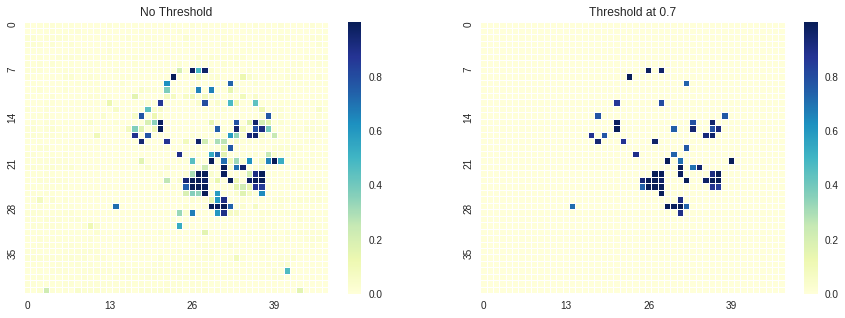

In [337]:
print('Fine Tuning Model')
gen_heatmap(slide_image4, x_test, model_ft, thres=0.7)

## just using architecture

In [0]:
import tensorflow as tf
vgg16_ = tf.keras.applications.VGG16(weights = None,input_shape=(40, 40, 3), include_top=False)

In [339]:
model_full = tf.keras.Sequential([
  vgg16_,
  #xception,
  tf.keras.layers.GlobalAveragePooling2D(),
  #tf.keras.layers.Flatten(), 
  #tf.keras.layers.Dense(256, activation='relu'),
  #tf.keras.layers.Dropout(0.3), # Add dropout to reduce overfitting
  tf.keras.layers.Dense(128, activation = 'relu'),
  tf.keras.layers.Dense(2, activation = 'softmax')])

model_full.compile(optimizer = tf.keras.optimizers.SGD(lr=0.0001, momentum = 0.9), 
            loss=tf.keras.losses.sparse_categorical_crossentropy,
            metrics=['accuracy'])

model_full.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 1, 1, 512)         14714688  
_________________________________________________________________
global_average_pooling2d_5 ( (None, 512)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 128)               65664     
_________________________________________________________________
dense_11 (Dense)             (None, 2)                 258       
Total params: 14,780,610
Trainable params: 14,780,610
Non-trainable params: 0
_________________________________________________________________


In [340]:
model_full.fit(X_sample, y_sample, batch_size = 64, epochs = 20, validation_split = 0.1)
#print('Evaluation')

#evaluation = model.evaluate(ds_test, steps = math.ceil(len(x_test)/32))

#print('Test set loss: ', evaluation[0])
#print('Test set accuracy: ', evaluation[1])

#visualize(model_history)

Train on 7419 samples, validate on 825 samples
Epoch 1/20
7419/7419 [==============================] - 16s 2ms/step - loss: 0.5026 - acc: 0.7636 - val_loss: 0.4180 - val_acc: 0.7891
Epoch 2/20
7419/7419 [==============================] - 14s 2ms/step - loss: 0.3398 - acc: 0.8538 - val_loss: 0.3120 - val_acc: 0.8630
Epoch 3/20
7419/7419 [==============================] - 14s 2ms/step - loss: 0.3075 - acc: 0.8710 - val_loss: 0.2703 - val_acc: 0.8836
Epoch 4/20
7419/7419 [==============================] - 14s 2ms/step - loss: 0.2734 - acc: 0.8858 - val_loss: 0.2812 - val_acc: 0.8921
Epoch 5/20
7419/7419 [==============================] - 14s 2ms/step - loss: 0.2825 - acc: 0.8845 - val_loss: 0.2818 - val_acc: 0.8885
Epoch 6/20
7419/7419 [==============================] - 14s 2ms/step - loss: 0.2508 - acc: 0.8943 - val_loss: 0.2887 - val_acc: 0.8921
Epoch 7/20
7419/7419 [==============================] - 14s 2ms/step - loss: 0.2536 - acc: 0.8919 - val_loss: 0.2455 - val_acc: 0.8933
Epoch 8/

In [341]:
from sklearn.metrics import roc_curve,  precision_score, recall_score, f1_score

y_predict_label_ = model_full.predict(X_sample).argmax(axis = 1)

print('Training Evaluation\n')

print('Recall: ', recall_score(y_sample, y_predict_label_))
print('F1: ', f1_score(y_sample, y_predict_label_))
print('Precision: ', precision_score(y_sample, y_predict_label_))
print('Average Precision: ', average_precision_score(y_sample, y_predict_label))

Training Evaluation

Recall:  0.9180009704027171
F1:  0.9373297002724795
Precision:  0.9574898785425101
Average Precision:  0.9052508309640089


In [342]:
print('Test 0 class: ', (y_test==0).sum())
print('Test 1 class: ', (y_test == 1).sum())

Test 0 class:  1946
Test 1 class:  70


In [344]:
y_pred_ = model_full.predict(x_test).argmax(axis =1)
y_pred_.mean()

0.07688492063492064

In [346]:
from sklearn.metrics import roc_curve,  precision_score, recall_score, f1_score
print('Test Set Evaluation\n')

evaluation = model_full.evaluate(x_test, y_test)

print('Loss: ', evaluation[0])
print('Accuracy: ', evaluation[1])

print('Recall: ', recall_score(y_test, y_pred_))
print('F1: ', f1_score(y_test, y_pred_))
print('Precision: ', precision_score(y_test, y_pred_))
print('Average Precision: ', average_precision_score(y_test, y_pred))

Test Set Evaluation

2016/2016 [==============================] - 1s 739us/step
Loss:  0.17059944031967056
Accuracy:  0.9270833333333334
Recall:  0.5571428571428572
F1:  0.3466666666666667
Precision:  0.25161290322580643
Average Precision:  0.2314647205914329


Model from Scracth, using VGG16 architecture
42 48
(42, 48)
(42, 48)


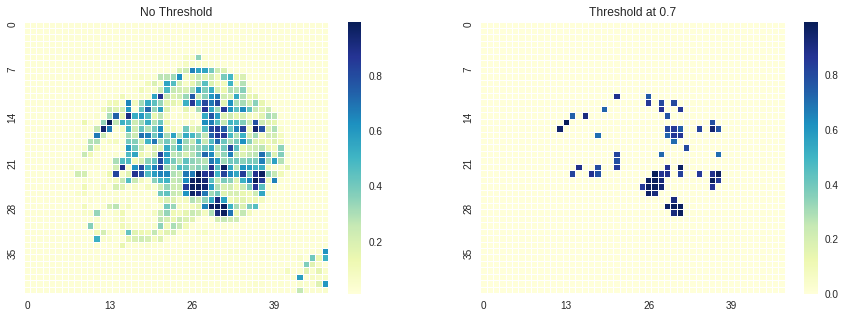

In [347]:
print('Model from Scracth, using VGG16 architecture')
gen_heatmap(slide_image4, x_test, model_full, thres=0.7)

** Questions**
- how to download
-- Prof will send an email and maybe upload all
- window size
-- same as model input size
- resize

## Heatmap Debugging

In [0]:
def gen_heatmap(slide_image, x_test, model, thres=0.9):
  import math
  width_lim = math.ceil(slide_image.shape[0]/40)
  height_lim = math.ceil(slide_image.shape[1]/40)

  print(width_lim, height_lim)

  base = np.zeros((width_lim, height_lim))
  pred = model.predict(x_test)[:,1]
  pred_thres = pred.copy()
  np.place(pred_thres, pred_thres<thres, 0)
  pred_1 = pred.reshape((int(slide_image.shape[0]/40), math.ceil(slide_image.shape[1]/40)))
  pred_2 = pred_thres.reshape((int(slide_image.shape[0]/40), math.ceil(slide_image.shape[1]/40)))
  print(pred_1.shape)
  print(pred_2.shape)
  
  #xticks = [0, 500, 1000, 1500, 2000, 2500]
  #yticks = [0, 250, 500, 750, 1000, 1250, 1500, 1750]
  #yticks = list(reversed(yticks))
  
  #plt.figure(figsize=(height_lim/10, width_lim/10), dpi=100)

  import seaborn
  fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5))

  seaborn.heatmap(pred_1, cmap='YlGnBu',yticklabels=7, xticklabels=13,linewidths=0.005, ax=ax1)
  seaborn.heatmap(pred_2, cmap='YlGnBu',yticklabels=7, xticklabels=13,linewidths=0.005, ax=ax2)
  ax1.set_title('No Threshold')
  ax2.set_title('Threshold at '+ str(thres))
  plt.show()

42 48
(42, 48)
(42, 48)


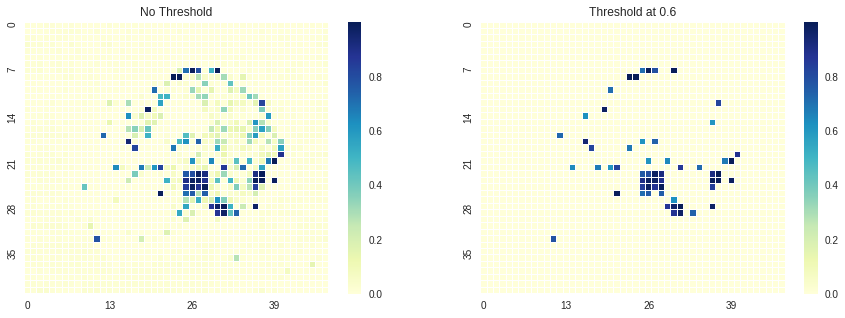

In [292]:
gen_heatmap(slide_image4, x_test, model, thres = 0.6)

In [0]:
xticks = [0, 500, 1000, 1500, 2000, 2500]
yticks = [0, 250, 500, 750, 1000, 1250, 1500, 1750]
yticks = list(reversed(yticks))

[Text(0,6.5,'1750'),
 Text(0,13.5,'1500'),
 Text(0,20.5,'1250'),
 Text(0,27.5,'1000'),
 Text(0,34.5,'750'),
 Text(0,41.5,'500'),
 Text(0,48.5,'250'),
 Text(0,55.5,'0')]

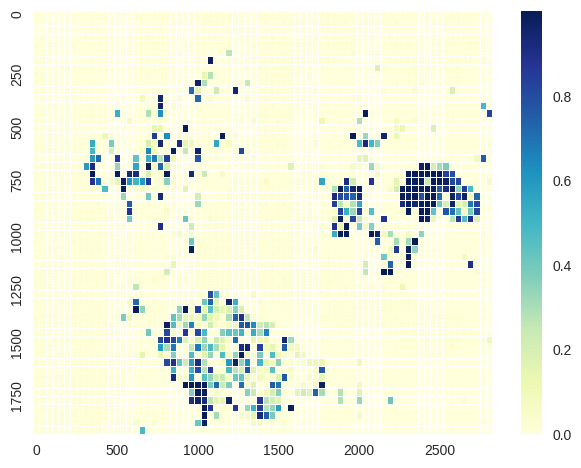

In [215]:
#xticks = [i for i in range(0, slide_image3.shape[0], 300)]
#yticks = list(reversed([i for i in range(0, slide_image3.shape[1], 300)]))
plt.figure(figsize=(height_lim/10, width_lim/10), dpi=100)

import seaborn
ax=seaborn.heatmap(pred_1, cmap='YlGnBu',yticklabels=7, xticklabels=13,linewidths=0.005)
ax.set_xticklabels(xticks)
ax.set_yticklabels(yticks)

[Text(0,6.5,'1750'),
 Text(0,13.5,'1500'),
 Text(0,20.5,'1250'),
 Text(0,27.5,'1000'),
 Text(0,34.5,'750'),
 Text(0,41.5,'500'),
 Text(0,48.5,'250'),
 Text(0,55.5,'0')]

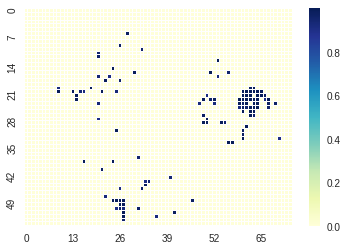

In [216]:
seaborn.heatmap(pred_2, cmap='YlGnBu',yticklabels=7, xticklabels=13,linewidths=0.005)
ax.set_xticklabels(xticks)
ax.set_yticklabels(yticks)

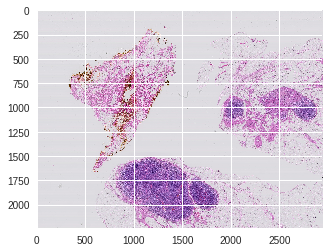

In [137]:
plt.imshow(slide_image3)